In [ ]:
!pip install torch torchvision torchaudio

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn

In [4]:
#bread_type = 'brown_bread'
bread_type = 'white_bread'
source_csv = f'dataframe_{bread_type}_normalized.csv'

df = pd.read_csv(source_csv)
df = df.dropna()
# Optionally, you can reset the index after dropping rows
df.reset_index(drop=True, inplace=True)
print(df)

    acrylamide_density  toaster_energy  toaster_temperature  room_temperature  \
0             0.552989        0.272727             0.484694          0.147959   
1             0.409255        0.272727             0.484694          0.134184   
2             0.279595        0.272727             0.484694          0.136735   
3             0.463340        0.272727             0.484694          0.138265   
4             0.579700        0.400000             0.770408          0.147959   
5             0.486400        0.454545             0.770408          0.147959   
6             0.606281        0.436364             0.770408          0.137755   
7             0.529397        0.454545             0.770408          0.140051   
8             0.502534        0.545455             0.938776          0.147959   
9             0.498115        0.545455             0.938776          0.147959   
10            0.740917        0.527273             0.938776          0.136735   
11            0.613852      

**RANDOM FOREST MODEL**

Mean Squared Error: 0.03003732769537307
R-squared: 0.4303213972505201


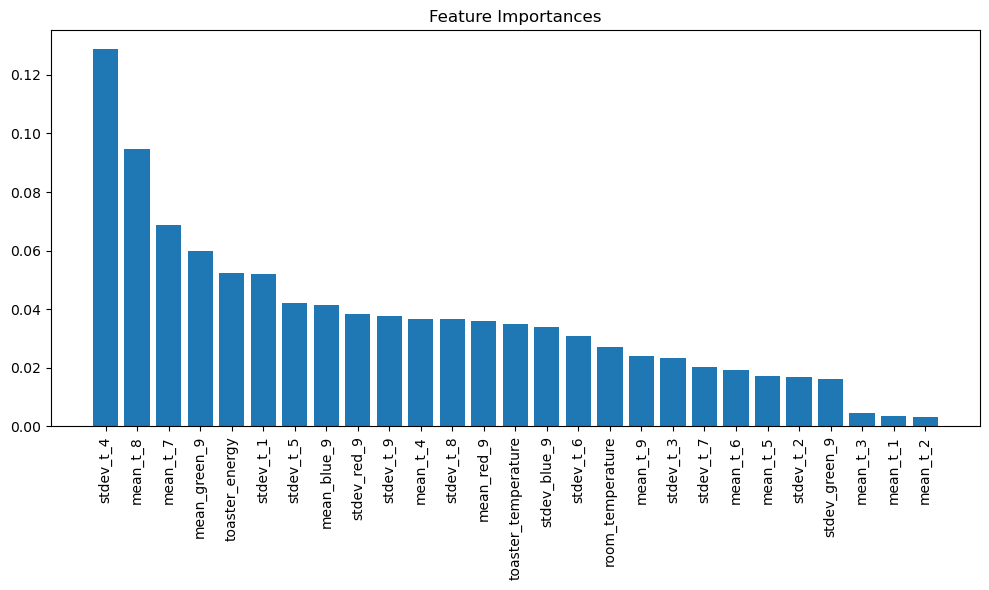

In [5]:
# Separate features and target variable
X = df.drop(columns=['acrylamide_density', 'mean_t_0', 'stdev_t_0'])# do not consider the temperature data for the first picture because it's very noisy
y = df['acrylamide_density']

# 2. Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Model training
# Using RandomForestRegressor as an example
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Predictions and Evaluation
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Optionally, plot feature importance if using Random Forest
importance = model.feature_importances_
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importance[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

**LSTM MODEL**

In [9]:
# Separate features and target variable and Convert to numpy arrays
sequential_columns = []
time_steps = 0
n_temp_features = 2
for j in range(1, 10):  # do not consider the temperature data for the first picture because it's very noisy
    time_steps += 1
    sequential_columns.extend([f'mean_t_{j}', f'stdev_t_{j}'])


other_columns = ['toaster_energy', 'toaster_temperature', 'room_temperature', 'mean_red_9', 'stdev_red_9', 'mean_green_9', 'stdev_green_9', 'mean_blue_9', 'stdev_blue_9']
X_temp = df[sequential_columns].to_numpy()
X_other = df[other_columns].to_numpy()
y = df['acrylamide_density']

# Reshape to (samples, time steps, features)
# the features are fed in 10 pairs one after the other
X_temp = X_temp.reshape(-1, time_steps, n_temp_features)
# print(df[sequential_columns].head(1))
# print('X_temp after reshape, first row')
# print(f'{X_temp[0]}')
# print(X_temp)
# Split the data into training and testing sets
X_temp_train, X_temp_test, X_other_train, X_other_test, y_train, y_test = train_test_split(
    X_temp, X_other, y, test_size=0.2, random_state=42
)
## ATTENTION: THE TEST SPLIT HAS NO GUARANTEE TO CONTAIN ONE ROW FOR EVERY DIFFERENT TOASTER FUNCTION

# Convert to PyTorch tensors
X_temp_train_tensor = torch.tensor(X_temp_train, dtype=torch.float32)
X_temp_test_tensor = torch.tensor(X_temp_test, dtype=torch.float32)
X_other_train_tensor = torch.tensor(X_other_train, dtype=torch.float32)
X_other_test_tensor = torch.tensor(X_other_test, dtype=torch.float32)
# Reshape for compatibility
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

############################################################################################################
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, other_input_size):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # Combining LSTM output and other features
        self.fc1 = nn.Linear(hidden_size + other_input_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x_temp, x_other):
        lstm_out, _ = self.lstm(x_temp)
        # Take the output from the last time step
        lstm_out_last = lstm_out[:, -1, :]
        # Concatenate with other features
        combined = torch.cat((lstm_out_last, x_other), dim=1)
        out = self.fc1(combined)
        out = self.fc2(out)
        return out

############################################################################################################

# Hyperparameters
input_size = 2  # Number of features for temperature
hidden_size = 64  # Number of LSTM units
output_size = 1   # Predicting a single value
other_input_size = X_other.shape[1]  # Number of additional features
num_epochs = 150  # Number of epochs
learning_rate = 0.001  # Learning rate

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, other_input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_temp_train_tensor, X_other_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_temp_test_tensor, X_other_test_tensor)
    test_loss = criterion(y_pred_tensor, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

# Optionally, convert predictions back to numpy for further analysis
y_pred = y_pred_tensor.numpy()
y_test = y_test_tensor.numpy()
print(f'y_pred == {y_pred}')
print(f'y_test == {y_test}')

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

Epoch [10/150], Loss: 0.1305
Epoch [20/150], Loss: 0.0614
Epoch [30/150], Loss: 0.0246
Epoch [40/150], Loss: 0.0249
Epoch [50/150], Loss: 0.0202
Epoch [60/150], Loss: 0.0182
Epoch [70/150], Loss: 0.0167
Epoch [80/150], Loss: 0.0154
Epoch [90/150], Loss: 0.0146
Epoch [100/150], Loss: 0.0140
Epoch [110/150], Loss: 0.0136
Epoch [120/150], Loss: 0.0133
Epoch [130/150], Loss: 0.0132
Epoch [140/150], Loss: 0.0131
Epoch [150/150], Loss: 0.0130
Test Loss: 0.0214
y_pred == [[0.442997  ]
 [0.45308205]
 [0.52405196]
 [0.73494625]]
y_test == [[0.55298865]
 [0.4092548 ]
 [0.48640013]
 [1.        ]]
Mean Absolute Error (MAE): 0.1141
Mean Squared Error (MSE): 0.0214
Root Mean Squared Error (RMSE): 0.1464
R-squared: 0.5937


In [33]:
# Convert to PyTorch tensors
X_temp_tensor = torch.tensor(X_temp, dtype=torch.float32)
X_other_tensor = torch.tensor(X_other, dtype=torch.float32)
# Reshape for compatibility
y_ground_truth = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_temp_tensor, X_other_tensor)
    test_loss = criterion(y_pred_tensor, y_ground_truth)
    print(f'Test Loss: {test_loss.item():.4f}')

# Optionally, convert predictions back to numpy for further analysis
y_pred = y_pred_tensor.numpy()
y_ground_truth = y_ground_truth.numpy()
print(f'y_pred == {y_pred}')
print(f'y_ground_truth == {y_ground_truth}')

Test Loss: 0.0167
y_pred == [[0.4449552 ]
 [0.45507553]
 [0.4548019 ]
 [0.4416766 ]
 [0.5309263 ]
 [0.5343926 ]
 [0.5353398 ]
 [0.55774754]
 [0.5954107 ]
 [0.61606735]
 [0.5974808 ]
 [0.5904158 ]
 [0.7053022 ]
 [0.7015663 ]
 [0.6974771 ]
 [0.707233  ]]
y_ground_truth == [[0.55298865]
 [0.4092548 ]
 [0.27959526]
 [0.46334007]
 [0.5796996 ]
 [0.48640013]
 [0.6062812 ]
 [0.5293975 ]
 [0.5025341 ]
 [0.49811488]
 [0.74091744]
 [0.61385196]
 [0.88914424]
 [0.8060322 ]
 [1.        ]
 [0.5271516 ]]


In [34]:
mae = mean_absolute_error(y_ground_truth, y_pred)
mse = mean_squared_error(y_ground_truth, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_ground_truth, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

Mean Absolute Error (MAE): 0.1060
Mean Squared Error (MSE): 0.0167
Root Mean Squared Error (RMSE): 0.1294
R-squared: 0.4736


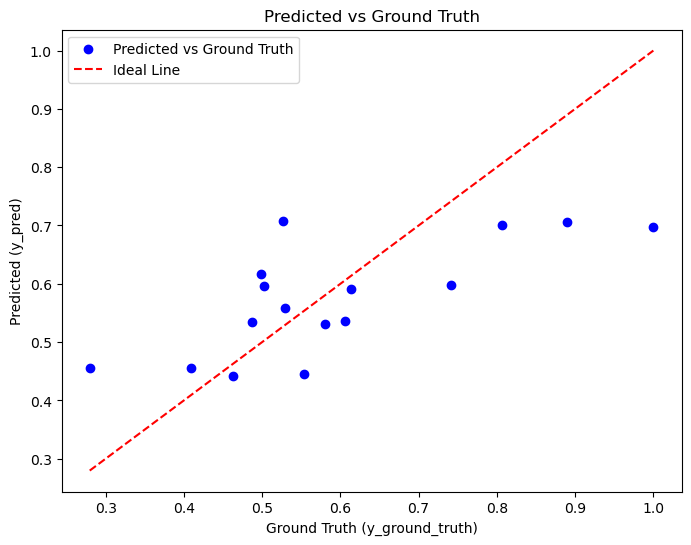

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(y_ground_truth, y_pred, color='blue',
            label='Predicted vs Ground Truth')
plt.plot([min(y_ground_truth), max(y_ground_truth)],
         [min(y_ground_truth), max(y_ground_truth)],
         color='red', linestyle='--', label='Ideal Line')

# Labels and title
plt.xlabel('Ground Truth (y_ground_truth)')
plt.ylabel('Predicted (y_pred)')
plt.title('Predicted vs Ground Truth')
plt.legend()

# Show plot
plt.show()

**VISUALIZE THE NETWORK STRUCTURE**

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 440.4 kB/s eta 0:00:00a 0:00:01
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=869b069513a6072d4d8a2d9ed5d3c7ad99f658ea57eb8f0bdd2caf0f0ba412f4
  Stored in directory: /Users/acarraro/Library/Caches/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


**PERFORM REGRESSION USING THE BURNT PIXELS RATIO USING RANDOM FOREST**

Results for dataframe_white_bread_threshold_method_<=0.1.csv ---------------------------------------------------
Mean Squared Error: 10372.616291922643
R-squared: 0.48192672684807225


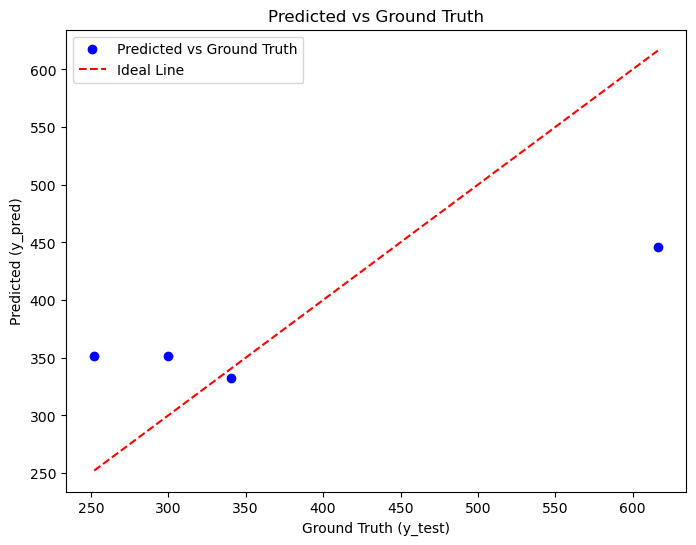

Results for dataframe_white_bread_threshold_method_<=0.2.csv ---------------------------------------------------
Mean Squared Error: 8214.841091548413
R-squared: 0.5896995036791648


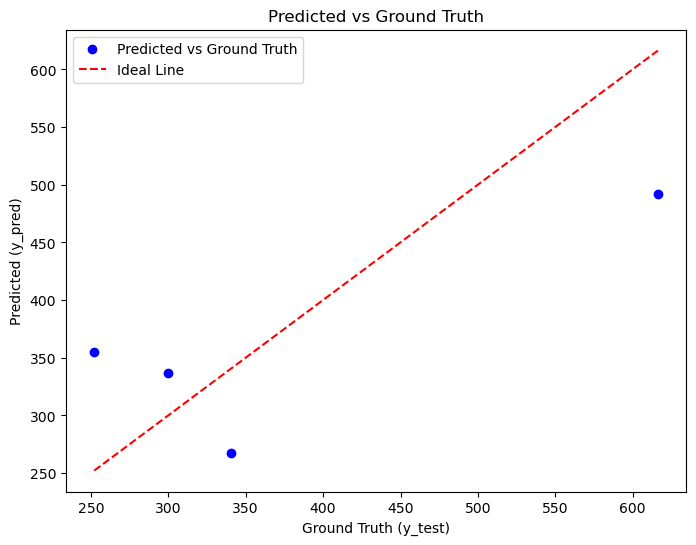

Results for dataframe_white_bread_threshold_method_<=0.3.csv ---------------------------------------------------
Mean Squared Error: 10048.475551311058
R-squared: 0.49811634089764467


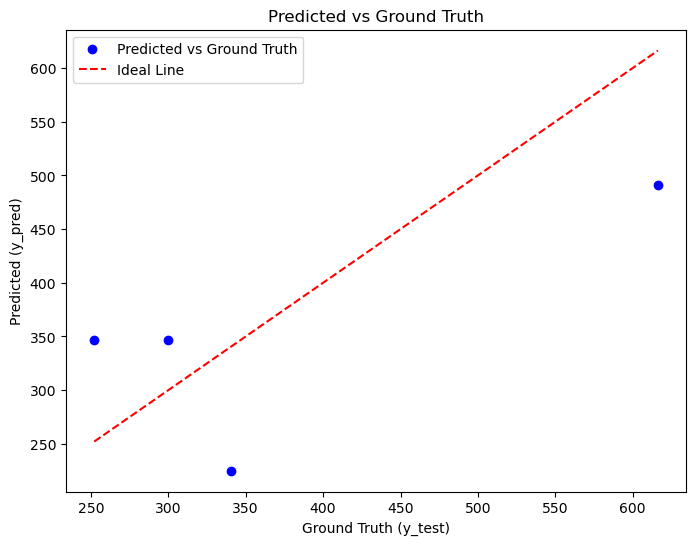

Results for dataframe_white_bread_threshold_method_<=0.4.csv ---------------------------------------------------
Mean Squared Error: 7541.947357207779
R-squared: 0.6233080214939755


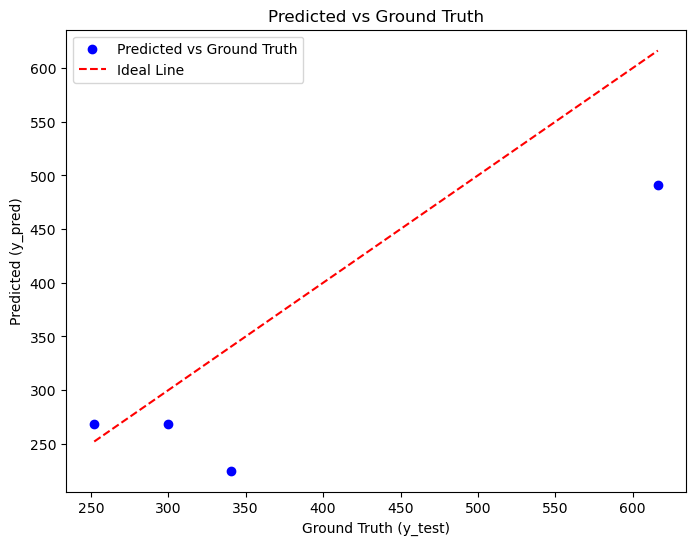

Results for dataframe_brown_bread_threshold_method_<=0.1.csv ---------------------------------------------------
Mean Squared Error: 2537.5996105115064
R-squared: 0.8919641922047976


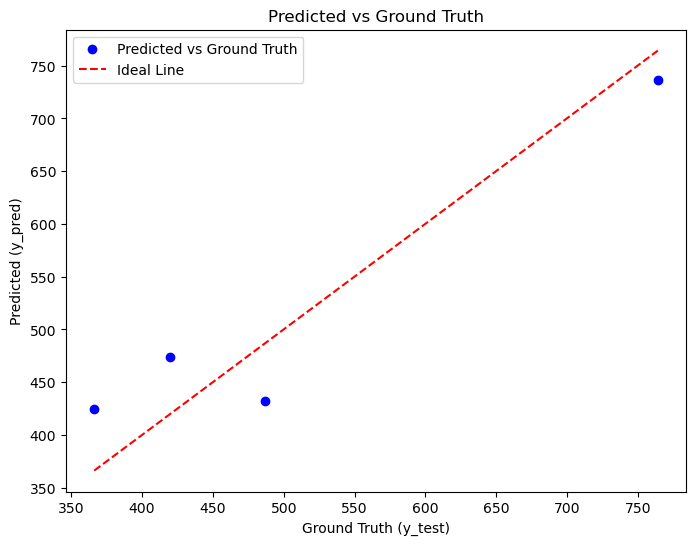

Results for dataframe_brown_bread_threshold_method_<=0.2.csv ---------------------------------------------------
Mean Squared Error: 1481.6137237683565
R-squared: 0.9369217528152491


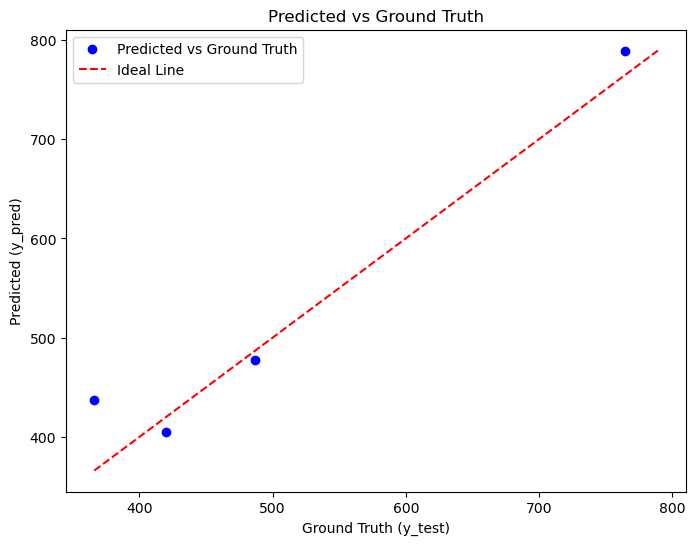

Results for dataframe_brown_bread_threshold_method_<=0.3.csv ---------------------------------------------------
Mean Squared Error: 7650.0876214523705
R-squared: 0.6743050430555946


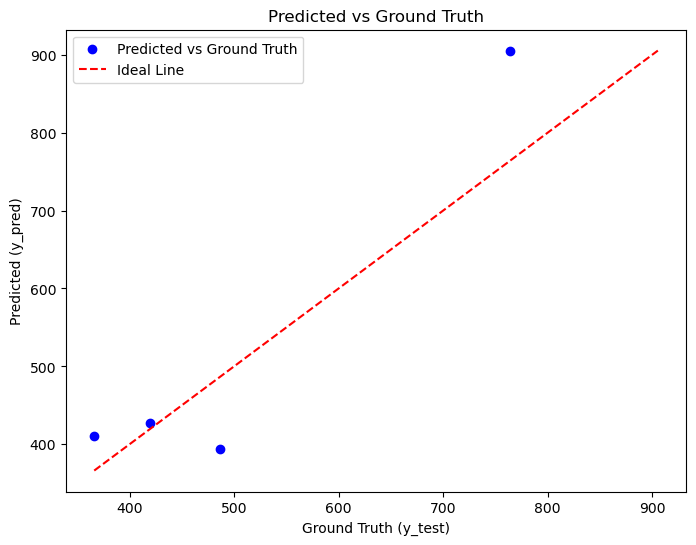

Results for dataframe_brown_bread_threshold_method_<=0.4.csv ---------------------------------------------------
Mean Squared Error: 10147.720484477944
R-squared: 0.5679707802289933


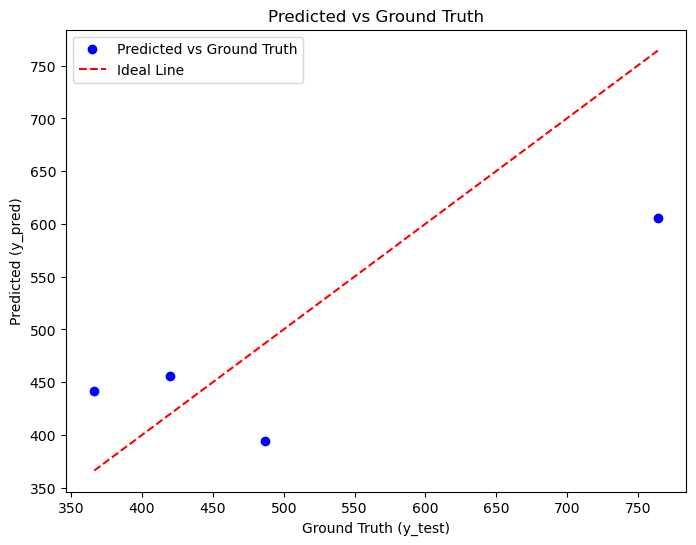

In [6]:
types = ['white', 'brown']
thresholds = [0.1, 0.2, 0.3, 0.4]

source_csvs = [
    f'dataframe_{t}_bread_threshold_method_<={th}.csv' for t in types for th in thresholds
    ]

###
columns_to_keep = ['burnt_pixels_ratio', 'acrylamide_density',
                   'mean_red_9', 'stdev_red_9', 
                   'mean_green_9', 'stdev_green_9', 
                   'mean_blue_9', 'stdev_blue_9']

for source_csv in source_csvs:
    df = pd.read_csv(source_csv)
    df = df[columns_to_keep]
    df = df.dropna()
    # Optionally, you can reset the index after dropping rows
    df.reset_index(drop=True, inplace=True)
    # Separate features and target variable
    # do not consider the temperature data for the first picture because it's very noisy
    X = df.drop(columns=['acrylamide_density', 'mean_red_9', 'stdev_red_9', 'mean_green_9', 'stdev_green_9', 'mean_blue_9', 'stdev_blue_9'])
    y = df['acrylamide_density']

    # 2. Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 3. Model training
    # Using RandomForestRegressor as an example
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 4. Predictions and Evaluation
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Results for {source_csv} ---------------------------------------------------")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue',
                label='Predicted vs Ground Truth')
    global_min = min(min(y_test), max(y_pred))
    global_max = max(max(y_test), max(y_pred))
    plt.plot([global_min, global_max],
             [global_min, global_max],
            color='red', linestyle='--', label='Ideal Line')

    # Labels and title
    plt.xlabel('Ground Truth (y_test)')
    plt.ylabel('Predicted (y_pred)')
    plt.title('Predicted vs Ground Truth')
    plt.legend()

    # Show plot
    plt.show()

**LINEAR REGRESSION FOR THE THRESHOLD METHOD**

Results for dataframe_white_bread_threshold_method_<=0.1.csv ---------------------------------------------------
Mean Squared Error (MSE): 6131.73677164872
R-squared coefficient: 0.4921321742153195


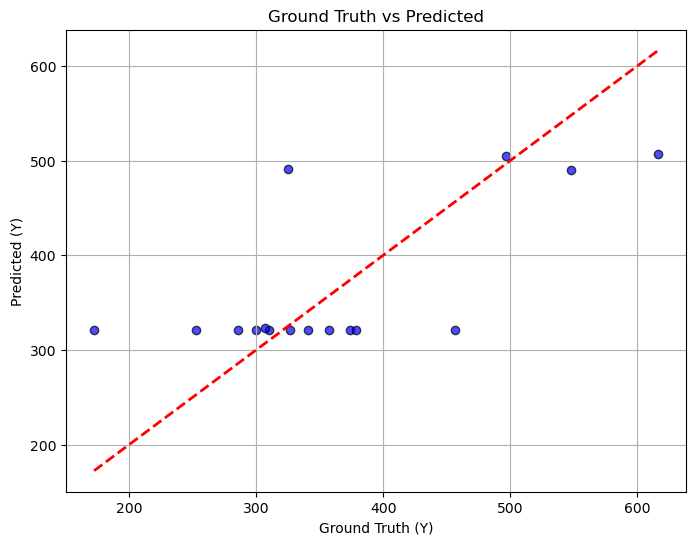

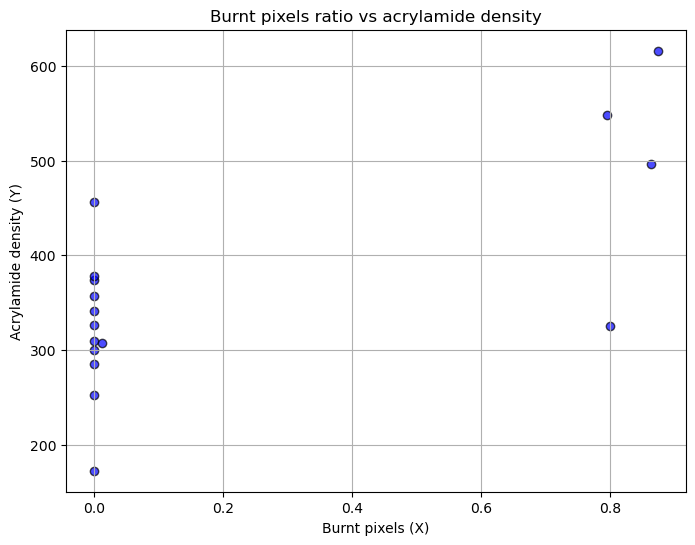

Results for dataframe_white_bread_threshold_method_<=0.2.csv ---------------------------------------------------
Mean Squared Error (MSE): 6147.545680122039
R-squared coefficient: 0.4908227840256596


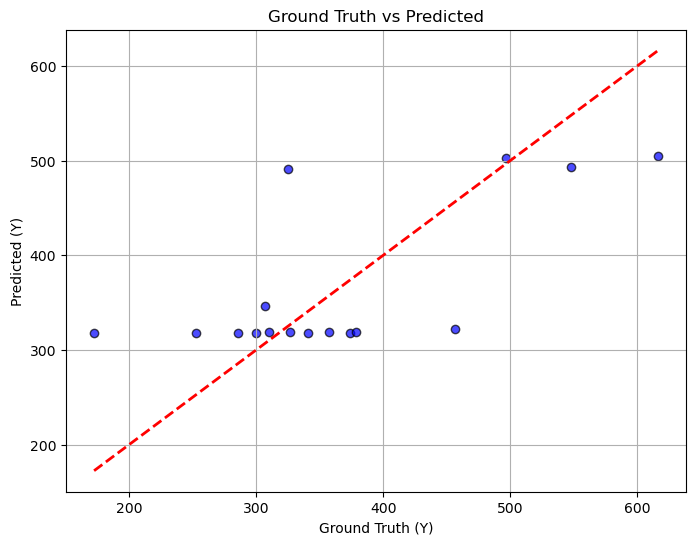

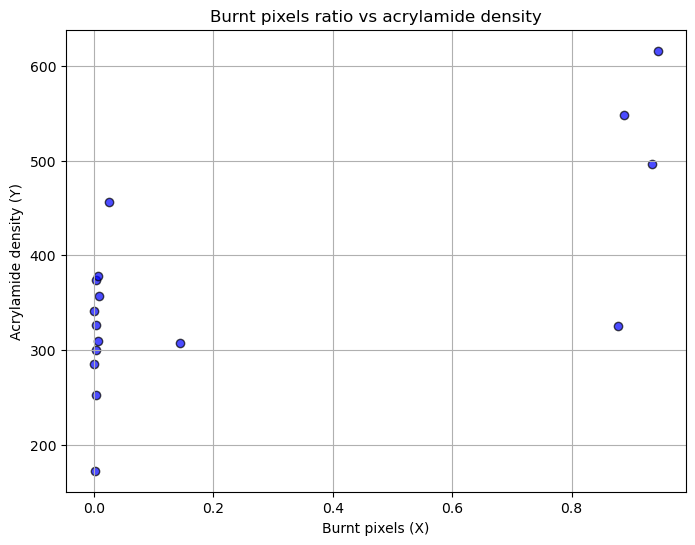

Results for dataframe_white_bread_threshold_method_<=0.3.csv ---------------------------------------------------
Mean Squared Error (MSE): 6221.373367447746
R-squared coefficient: 0.4847079248199967


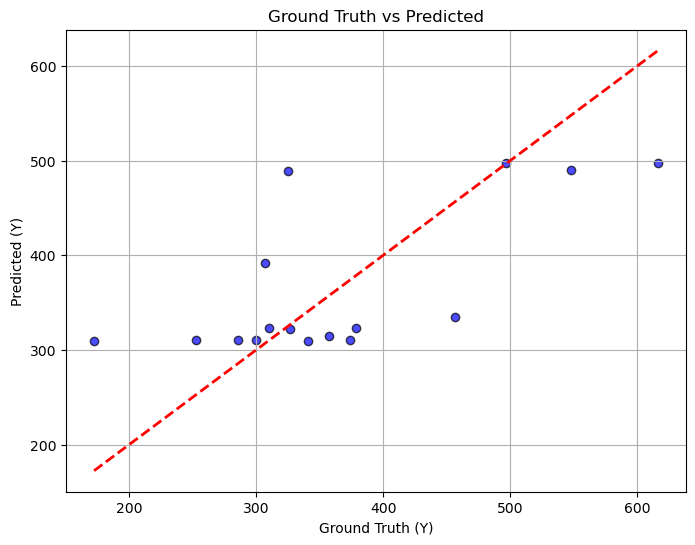

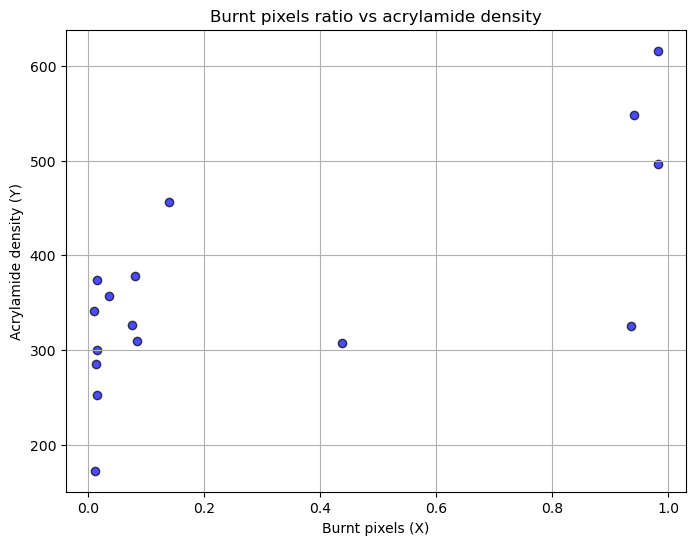

Results for dataframe_white_bread_threshold_method_<=0.4.csv ---------------------------------------------------
Mean Squared Error (MSE): 6272.49465835707
R-squared coefficient: 0.4804737478107244


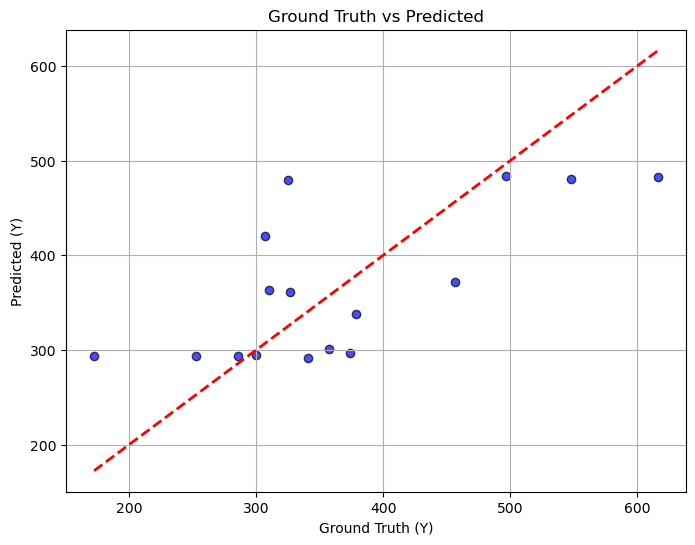

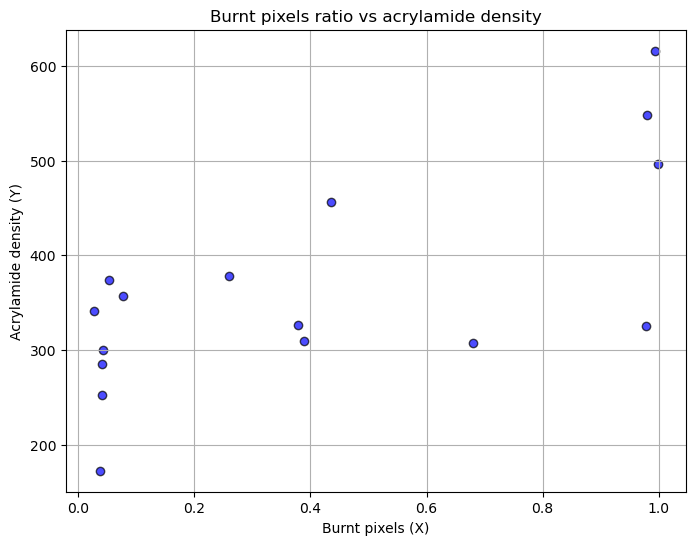

Results for dataframe_brown_bread_threshold_method_<=0.1.csv ---------------------------------------------------
Mean Squared Error (MSE): 6083.400600758902
R-squared coefficient: 0.8081594743650777


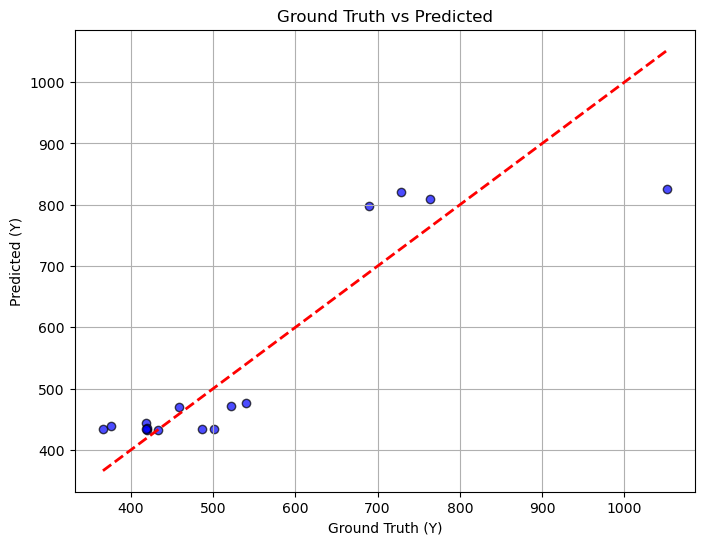

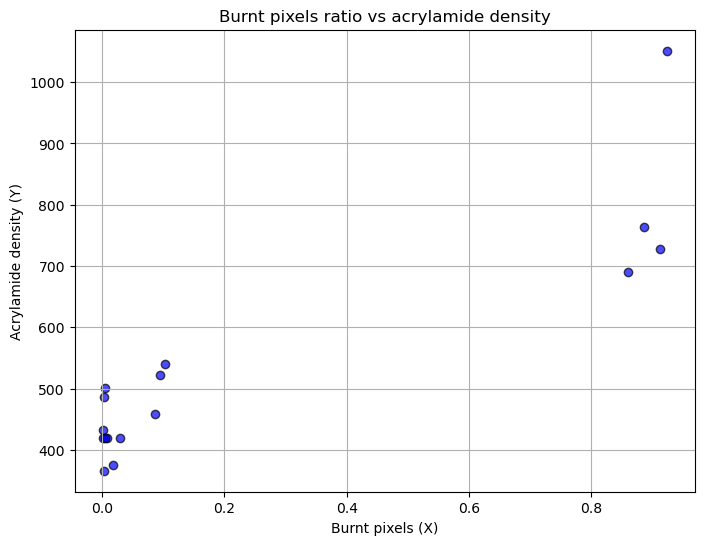

Results for dataframe_brown_bread_threshold_method_<=0.2.csv ---------------------------------------------------
Mean Squared Error (MSE): 10408.036025543199
R-squared coefficient: 0.6717817495500249


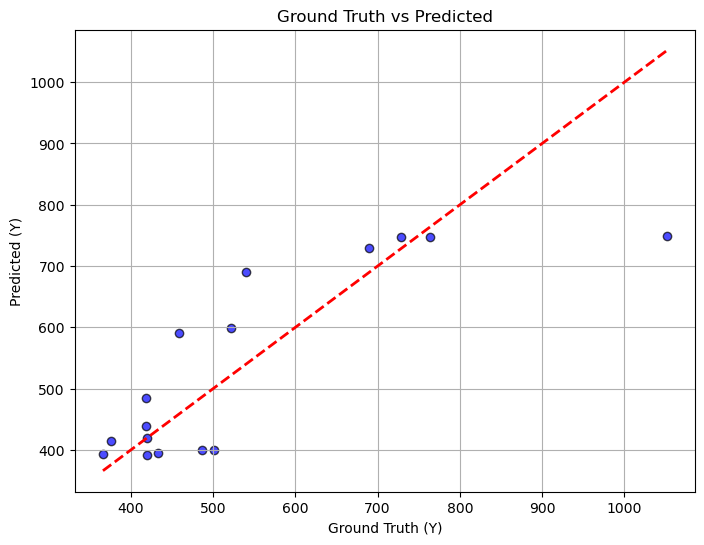

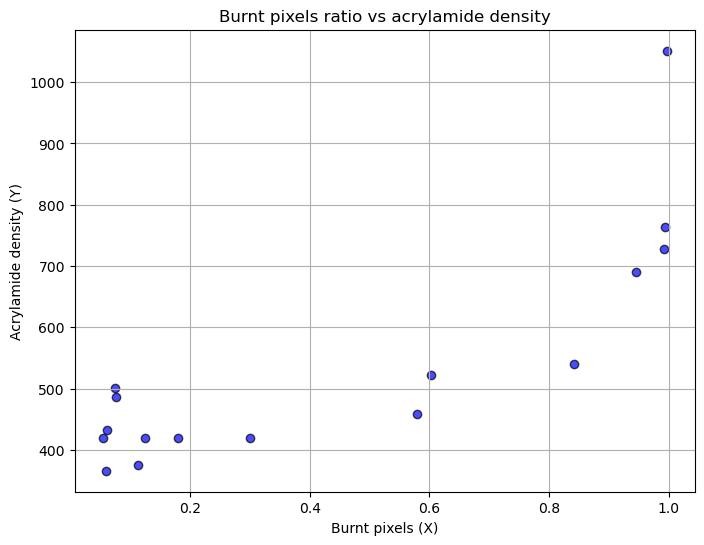

Results for dataframe_brown_bread_threshold_method_<=0.3.csv ---------------------------------------------------
Mean Squared Error (MSE): 19852.581161667855
R-squared coefficient: 0.37394726153835667


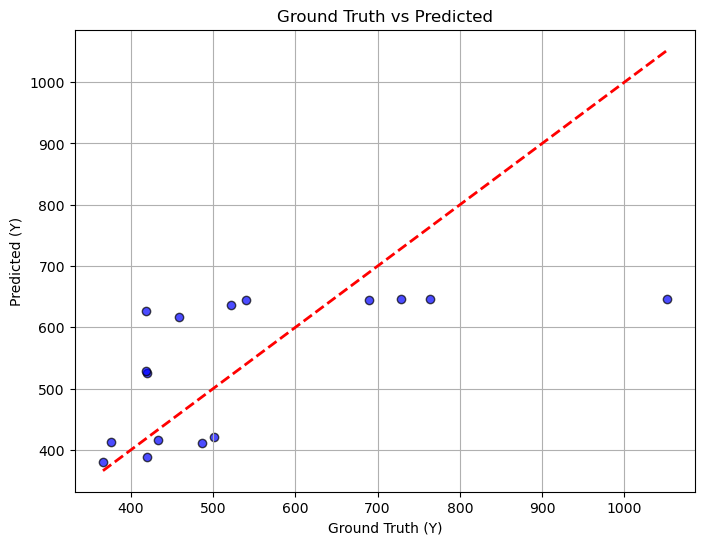

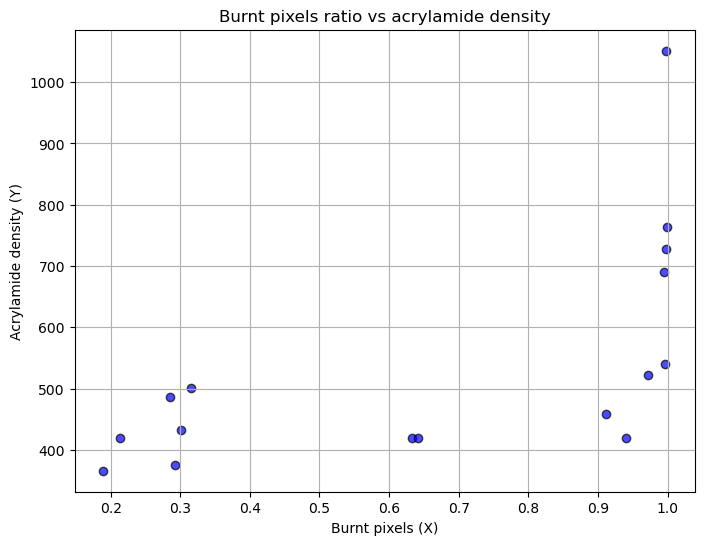

Results for dataframe_brown_bread_threshold_method_<=0.4.csv ---------------------------------------------------
Mean Squared Error (MSE): 25202.424428657698
R-squared coefficient: 0.2052395252311754


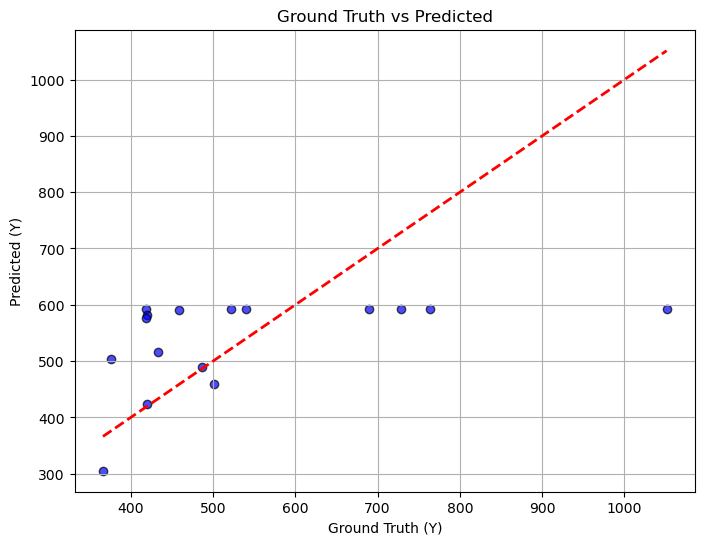

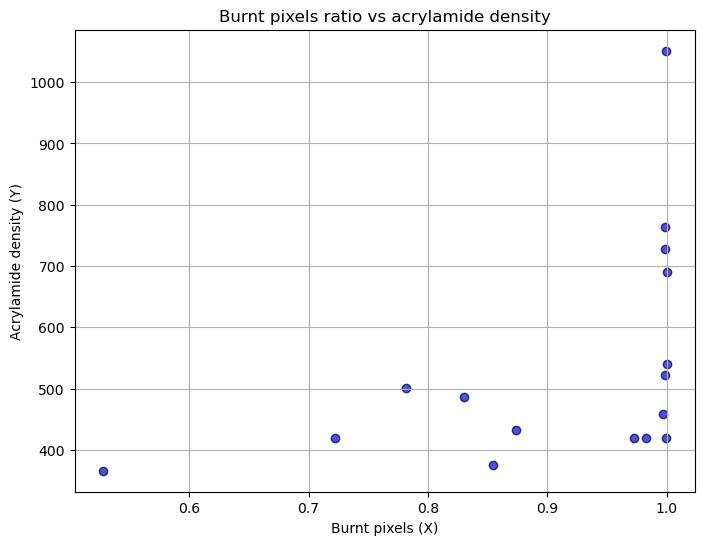

In [6]:
types = ['white', 'brown']
thresholds = [0.1, 0.2, 0.3, 0.4]

source_csvs = [
    f'dataframe_{t}_bread_threshold_method_<={th}.csv' for t in types for th in thresholds
]

for source_csv in source_csvs:
    df = pd.read_csv(source_csv)
    df = df.dropna()
    # Optionally, you can reset the index after dropping rows
    df.reset_index(drop=True, inplace=True)

    # Assuming df['X'] and df['Y'] contain numerical data
    X = df[['burnt_pixels_ratio']]  # Feature (independent variable)
    Y = df['acrylamide_density']    # Target (dependent variable)

    # Initialize and train the Linear Regression model
    model = LinearRegression()
    model.fit(X, Y)

    # Make predictions
    predictions = model.predict(X)
    
    print(f"Results for {source_csv} ---------------------------------------------------")
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Y, predictions)
    print(f"Mean Squared Error (MSE): {mse}")

    # Calculate R-squared coefficient
    r2 = r2_score(Y, predictions)
    print(f"R-squared coefficient: {r2}")

    # Plot ground truth vs predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(Y, predictions, color='blue', edgecolor='k', alpha=0.7)
    plt.plot([min(Y), max(Y)], [min(Y), max(Y)], color='red', linestyle='--', linewidth=2)  # Identity line
    plt.xlabel('Ground Truth (Y)')
    plt.ylabel('Predicted (Y)')
    plt.title('Ground Truth vs Predicted')
    plt.grid(True)
    plt.show()

    # Plot burnt pixels ratio truth vs acrylamide content
    plt.figure(figsize=(8, 6))
    plt.scatter(X, Y, color='blue', edgecolor='k', alpha=0.7)
    #plt.plot([min(X), max(X)], [min(Y), max(Y)], color='red', linestyle='--', linewidth=2)  # Identity line
    plt.xlabel('Burnt pixels (X)')
    plt.ylabel('Acrylamide density (Y)')
    plt.title('Burnt pixels ratio vs acrylamide density')
    plt.grid(True)
    plt.show()